## Exploring LUNA16 datasets

Obtain the dataset from LUNA16 page https://luna16.grand-challenge.org/data/, and store them in `inputs` folder.

Reference:
- https://www.kaggle.com/c/data-science-bowl-2017#tutorial

### Lung Nodule

> Lung nodules — small masses of tissue in the lung — are quite common. They appear as round, white shadows on a chest X-ray or computerized tomography (CT) scan.

> Lung nodules are usually about 0.2 inch (5 millimeters) to 1.2 inches (30 millimeters) in size. A larger lung nodule, such as one that's 30 millimeters or larger, is more likely to be cancerous than is a smaller lung nodule.

Reference:
- http://www.mayoclinic.org/diseases-conditions/lung-cancer/expert-answers/lung-nodules/faq-20058445
- http://emedicine.medscape.com/article/2139920-overview

In [1]:
import SimpleITK
import numpy as np
import csv
from glob import glob
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

luna_path = "../inputs"
luna_subset_path = luna_path + "/subset*/"

### Dataset

The data are stored in .mhd and .raw files. .raw file contains raw images and the corresponding .mhd file contains metadata such as voxel resolution.

In [2]:
mhd_file_list = glob(luna_subset_path + "*.mhd")

len(mhd_file_list)

888

## Plot the all slices of a scan

A scan contains about 100-300 slices. The voxel resolution (i.e. slice thickness and slice spacing) vary from sample to sample. See the metadata bundled in mhd files.

img_array.shape =  (121, 512, 512)


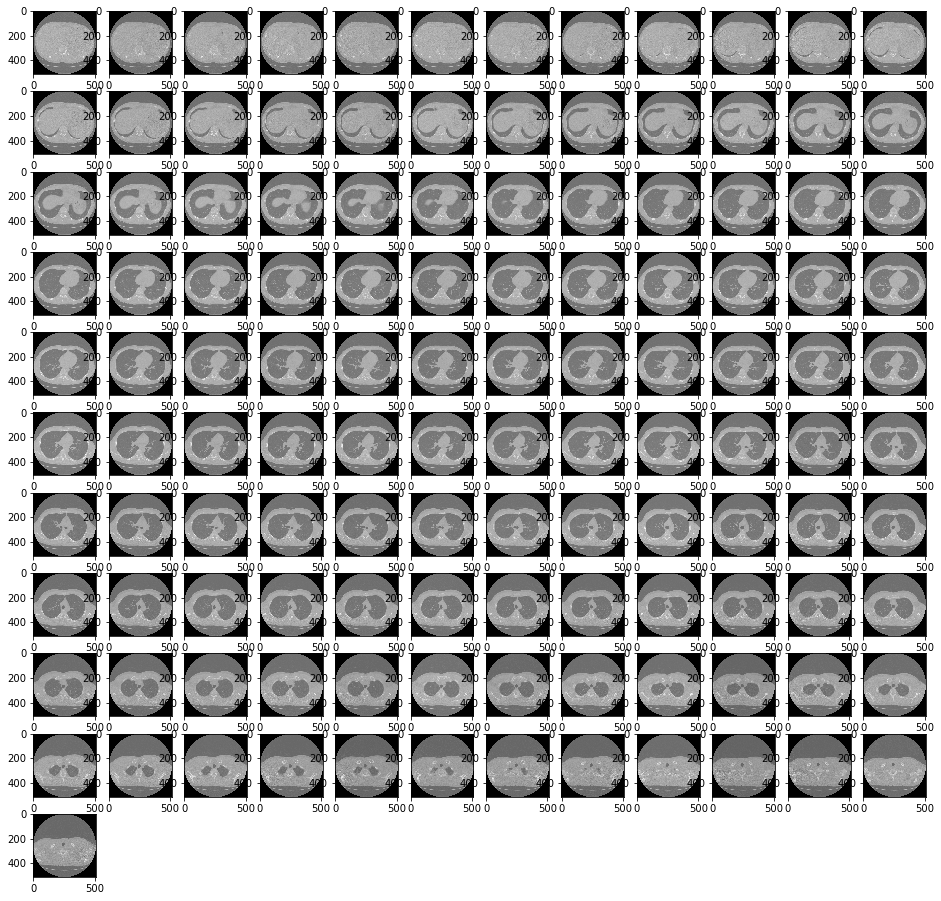

In [3]:
import math

def plot_mhd_file(mhd_file):
    itk_img = SimpleITK.ReadImage(mhd_file) 
    img_array = SimpleITK.GetArrayFromImage(itk_img) # z,y,x ordering
    
    print("img_array.shape = ", img_array.shape)
    
    n_images = img_array.shape[0]
    ncol = 12
    nrow = math.ceil(n_images / ncol)
    
    plt.figure(figsize=(16, 16))
    for i in range(0, n_images):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(img_array[i], cmap=plt.cm.gray)

plot_mhd_file(mhd_file_list[0])

## Load the annoations

The annotations from doctors are stored in the csv file.

> The reference standard of our challenge consists of all nodules >= 3 mm accepted by at least 3 out of 4 radiologists.

https://luna16.grand-challenge.org/data/

In [4]:
def load_df(path):    
    def get_filename(case):
        global mhd_file_list
        for f in mhd_file_list:
            if case in f:
                return(f)

    df_node = pd.read_csv(path)
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    
    return df_node

df = load_df(luna_path + "/CSVFILES/annotations.csv")

print("len(df) =", len(df))

df.head()

len(df) = 1186


,seriesuid,coordX,coordY,coordZ,diameter_mm,file
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,../../LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,../../LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,../../LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,../../LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,../../LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6...


## Plot slices that contain the annotated nodules

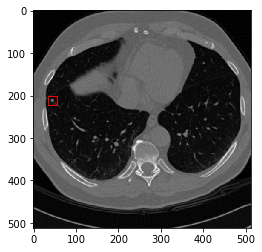

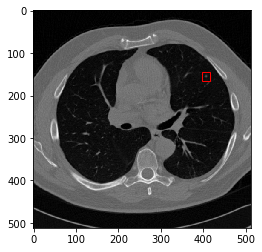

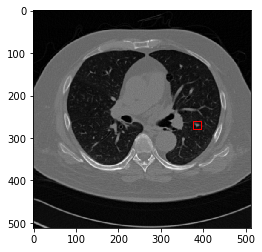

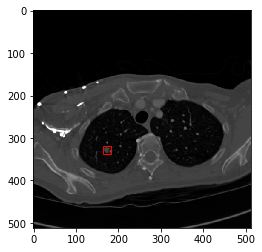

In [5]:
def plot_nodule(nodule_info):
    mhd_file = nodule_info[5]
    itk_img = SimpleITK.ReadImage(mhd_file) 
    img_array = SimpleITK.GetArrayFromImage(itk_img)  # z,y,x ordering
    origin_xyz = np.array(itk_img.GetOrigin())   # x,y,z  Origin in world coordinates (mm)
    spacing_xyz = np.array(itk_img.GetSpacing()) # spacing of voxels in world coor. (mm)
    center_xyz = (nodule_info[1], nodule_info[2], nodule_info[3])
    nodule_xyz = np.rint((center_xyz - origin_xyz) / spacing_xyz).astype(np.int16)

    import matplotlib.patches as patches
    fig, ax = plt.subplots(1)
    ax.imshow(img_array[nodule_xyz[2]], cmap=plt.cm.gray)
    ax.add_patch(
        patches.Rectangle(
            (nodule_xyz[0] - 10, nodule_xyz[1]-10),   # (x,y)
            20,          # width
            20,          # height
            linewidth=1, edgecolor='r', facecolor='none'
        )
    )

plot_nodule(df.iloc[0])
plot_nodule(df.iloc[1])
plot_nodule(df.iloc[2])
plot_nodule(df.iloc[3])

## Plot histogram of the nodule sizes (mm)

(array([  78.,  238.,  215.,  161.,   87.,   75.,   51.,   40.,   30.,
          33.,   27.,   20.,   17.,   15.,   24.,   11.,   11.,   10.,
          11.,   10.,    6.,    5.,    5.,    1.,    2.,    1.,    0.,
           0.,    1.,    1.]),
 array([  3.2534432 ,   4.22066276,   5.18788233,   6.1551019 ,
          7.12232147,   8.08954104,   9.05676061,  10.02398018,
         10.99119974,  11.95841931,  12.92563888,  13.89285845,
         14.86007802,  15.82729759,  16.79451715,  17.76173672,
         18.72895629,  19.69617586,  20.66339543,  21.630615  ,
         22.59783457,  23.56505413,  24.5322737 ,  25.49949327,
         26.46671284,  27.43393241,  28.40115198,  29.36837154,
         30.33559111,  31.30281068,  32.27003025]),
 <a list of 30 Patch objects>)

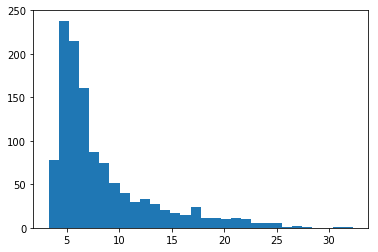

In [6]:
nodule_sizes = list(df['diameter_mm'])

plt.hist(nodule_sizes, bins=30)

## MHD File Format

Similar to DICOM format, the file contains metadata in addition to raw images. For example,

* Spacing
    * Voxel resoution (slice thickness and resolution) in mm
* Origin
    * The coordinates of the origin point in the world coordinates.

http://www.simpleitk.org/

In [7]:
print(SimpleITK.ReadImage(mhd_file_list[0]))

Image (0xace78d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 1939
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1914
  UpdateMTime: 1938
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 121]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 121]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 121]
  Spacing: [0.761719, 0.761719, 2.5]
  Origin: [-198.1, -195, -335.21]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.761719 0 0
0 0.761719 0
0 0 2.5

  PointToIndexMatrix: 
1.31282 0 0
0 1.31282 0
0 0 0.4

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0xa453410)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference C